<a href="https://colab.research.google.com/github/Meghana17-10/GNNAID-P/blob/main/GNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.9 MB/s eta 0:00:00


In [ ]:
pip install --index-url https://download.pytorch.org/whl/cpu torch torchvision torchaudio


Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
pip install torch_geometric

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Get the first graph object

Processing...
Done!


In [ ]:
# Initialize model, optimizer, and loss function
model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    return loss.item()

In [ ]:
# Evaluation function
def test():
    model.eval()
    with torch.no_grad():  # No gradients needed for evaluation
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Get the predicted classes
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [ ]:
# Run the training process
for epoch in range(200):  # Number of epochs
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("Training completed.")

Epoch: 0, Loss: 1.9651, Test Accuracy: 0.3470
Epoch: 10, Loss: 0.6611, Test Accuracy: 0.7080
Epoch: 20, Loss: 0.1118, Test Accuracy: 0.7800
Epoch: 30, Loss: 0.0237, Test Accuracy: 0.7710
Epoch: 40, Loss: 0.0087, Test Accuracy: 0.7740
Epoch: 50, Loss: 0.0049, Test Accuracy: 0.7770
Epoch: 60, Loss: 0.0034, Test Accuracy: 0.7770
Epoch: 70, Loss: 0.0028, Test Accuracy: 0.7750
Epoch: 80, Loss: 0.0023, Test Accuracy: 0.7740
Epoch: 90, Loss: 0.0020, Test Accuracy: 0.7730
Epoch: 100, Loss: 0.0018, Test Accuracy: 0.7720
Epoch: 110, Loss: 0.0016, Test Accuracy: 0.7720
Epoch: 120, Loss: 0.0015, Test Accuracy: 0.7740
Epoch: 130, Loss: 0.0013, Test Accuracy: 0.7740
Epoch: 140, Loss: 0.0012, Test Accuracy: 0.7740
Epoch: 150, Loss: 0.0011, Test Accuracy: 0.7750
Epoch: 160, Loss: 0.0010, Test Accuracy: 0.7720
Epoch: 170, Loss: 0.0010, Test Accuracy: 0.7720
Epoch: 180, Loss: 0.0009, Test Accuracy: 0.7730
Epoch: 190, Loss: 0.0008, Test Accuracy: 0.7730
Training completed.


In [ ]:
# 4. Save Trained Model
# -------------------
torch.save(model.state_dict(), "gcn_cora.pth")
print("✅ Model saved as gcn_cora.pth")

✅ Model saved as gcn_cora.pth


In [ ]:
# 5. Reload Model
# -------------------
model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
model.load_state_dict(torch.load("gcn_cora.pth"))
model.eval()
print("✅ Model reloaded")

✅ Model reloaded


In [ ]:
# ----------------------------
# FGSM Attack
# ----------------------------
def fgsm_attack(model, data, epsilon=0.01):
    model.eval()
    x_adv = data.x.clone().detach().to(device)
    x_adv.requires_grad = True

    out = model(x_adv, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()

    # FGSM perturbation
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    return x_adv.detach()


In [ ]:
# ----------------------------
# PGD Attack
# ----------------------------
def pgd_attack(model, data, epsilon=0.01, alpha=0.005, iters=20):
    model.eval()
    x_adv = data.x.clone().detach().to(device)
    x_adv.requires_grad = True

    for _ in range(iters):
        out = model(x_adv, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()

        # Gradient step
        x_adv = x_adv + alpha * x_adv.grad.sign()
        # Projection step (keep perturbation bounded)
        perturbation = torch.clamp(x_adv - data.x, -epsilon, epsilon)
        x_adv = (data.x + perturbation).detach()
        x_adv.requires_grad = True

    return x_adv

In [ ]:
# ----------------------------
# Evaluate on clean + adversarial
# ----------------------------
clean_acc = test()
print(f"Clean Accuracy: {clean_acc:.4f}")

# FGSM attack
x_adv_fgsm = fgsm_attack(model, data, epsilon=0.01)
adv_acc_fgsm = test(x=x_adv_fgsm)
print(f"⚡ Accuracy after FGSM Attack: {adv_acc_fgsm:.4f}")

# PGD attack
x_adv_pgd = pgd_attack(model, data, epsilon=0.01, alpha=0.005, iters=20)
adv_acc_pgd = test(x=x_adv_pgd)
print(f"⚡ Accuracy after PGD Attack: {adv_acc_pgd:.4f}")

Clean Accuracy: 0.7830
⚡ Accuracy after FGSM Attack: 0.5230
⚡ Accuracy after PGD Attack: 0.4180


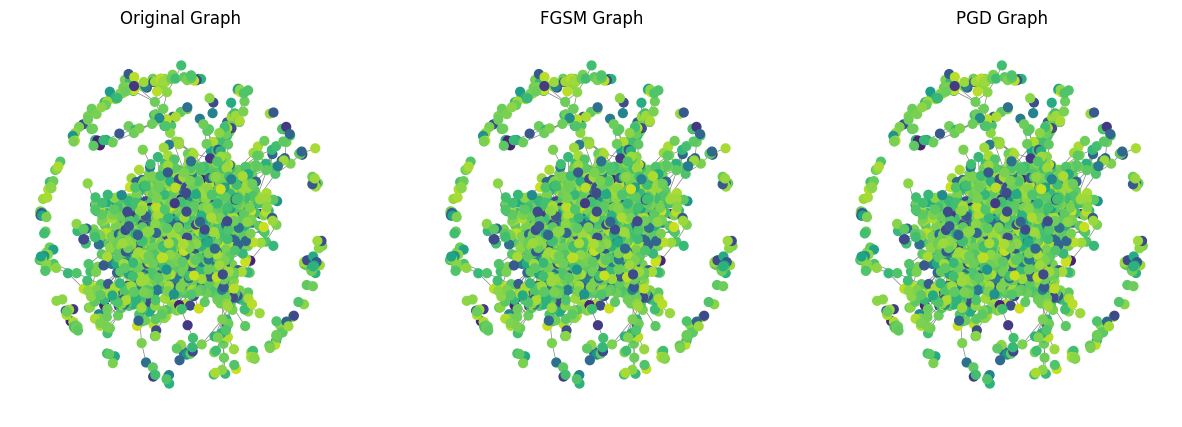

In [ ]:
# ----------------------------
# Visualization
# ----------------------------
def plot_graph(data, title, node_features=None):
    G = nx.Graph()
    edge_index = data.edge_index.numpy()
    G.add_edges_from(edge_index.T)
    pos = nx.spring_layout(G, seed=42)

    if node_features is not None:
        node_color = node_features.detach().norm(dim=1).numpy()
    else:
        node_color = data.y.numpy()

    nx.draw(
        G, pos,
        node_color=node_color,
        cmap=plt.cm.viridis,
        node_size=40,
        edge_color="gray",
        width=0.5,
        with_labels=False
    )
    plt.title(title)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_graph(data, "Original Graph", node_features=data.x)

plt.subplot(1, 3, 2)
plot_graph(data, "FGSM Graph", node_features=x_adv_fgsm)

plt.subplot(1, 3, 3)
plot_graph(data, "PGD Graph", node_features=x_adv_pgd)

plt.show()

In [ ]:
def plot_interactive_graph(data, dataset, node_features=None, title="Graph"):
    edge_index = data.edge_index.cpu().numpy()
    G = nx.Graph()

    # Add edges
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])

    # Node labels
    labels = {i: dataset[0].y[i].item() for i in range(data.num_nodes)}

    # Color nodes: if adversarial features given, use them; else use dataset labels
    if node_features is not None:
        colors = node_features.detach().norm(dim=1).cpu().numpy()
        node_color = [f'rgba({int(c*255)}, 50, 150, 0.7)' for c in colors]
    else:
        colors = np.array([dataset[0].y[i].item() for i in range(data.num_nodes)])
        node_color = [f'rgba(0, 0, {255 - (c * 25)}, 0.7)' for c in colors]

    pos = nx.spring_layout(G, k=0.5, iterations=50)

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x, node_y = [], []
    for i in range(data.num_nodes):
        x, y = pos[i]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(showscale=True,
                    colorscale='Blues',
                    size=10,
                    color=node_color,
                    line=dict(width=2)),
        text=[f'Node {i}: {labels[i]}' for i in range(data.num_nodes)]
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    pyo.iplot(fig)

In [ ]:
# Original graph
plot_interactive_graph(data, dataset, node_features=data.x.detach(), title="Original Graph")

# FGSM graph
plot_interactive_graph(data, dataset, node_features=x_adv_fgsm.detach(), title="FGSM Attacked Graph")

# PGD graph
plot_interactive_graph(data, dataset, node_features=x_adv_pgd.detach(), title="PGD Attacked Graph")